This notebook has a solution using Time Series with the Prophet model from Facebook, to predict the number of bicycles that will be rented in the future from the Seoul Bike Data dataset.

The dataset contains the amount of bicycles rented in the city of Seoul (South Korea) between 2017 and 2018.

This forecasting model will answer the second business question from the dataset of Summative Activities 1 and 2:
- Predict how many bikes would be rented in the future (i.e. for the entire month of January 2019 – which information does not exist in this dataset).

Therefore, the forecast will show 31 days ahead. That is, the month of January 2019, but it will also show forecast of the data that already exists, and then we can analiyze it.

In addition, an analysis of model metrics.

In [ ]:
#Installing, updating and importing useful libraries for the model
!conda install -c conda-forge prophet -y
!pip install --upgrade plotly
!pip install seaborn
import pandas as pd 
import seaborn as sns
import numpy as np
from scipy import stats
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

Solving environment: done

# All requested packages already installed.



## Forecasting



This is the step of loading and splitting the data. The step of splitting the data into Time Series separates the most recent entries and tests with the old ones. Therefore, the data needs to be sorted by date and for that the sort_values ​​function is used.

In [79]:
#Load the xlsx file
df = pd.read_excel('/Users/veronicascheifer/Desktop/PUC/Machine_Learning/Activity_2/seoul_bike_data.xlsx')

In [80]:
#Split Data

df_train = df.iloc[:-124]
df_test = df.iloc[-124:]
df_train = df_train.sort_values(by='DateTime')
df_test = df_test.sort_values(by='DateTime')

Essa é a preparação dos dados. Aqui criamos uma função 'preparação' que executará todas as transformações necessárias na base de dados e retornará um dataframe com os dados limpos.

In [81]:
#Data Preparation

def dataPreparation(df):
    
    #Delete blank data, but when necessary average blank data to improve accuracy in the model
    df  = df.dropna()

    #Convert column 'DateTime' to datetime 
    df['DateTime'] = pd.to_datetime(df['DateTime'])

    #Separate and create a column to date
    df['Date'] = df['DateTime'].dt.strftime('%Y-%m-%d')

    #Separate and create a column to hour
    df['Hora'] = df['DateTime'].dt.strftime('%H:%M:%S')

    #Delete column hour and datetime
    df = df.drop(columns=['Hora','DateTime'])

    #Order columns
    df = df[['Date', 'Rented Bike Count', 'Day', 'Weekday', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']]

    #Prophet must have columns with the date name of "ds" and the value of "y"
    df = df.rename(columns={'Date': 'ds', 'Rented Bike Count': 'y'})

    df = df.drop(columns=['Day','Weekday', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Visibility (10m)'])

    return df

In [82]:
df_train = dataPreparation(df_train)
df_test = dataPreparation(df_test)

Now we will do one more transformation, which is the grouping of bicycle values ​​per day for the two datasets (training and testing).

In [83]:
#Group by day and add the total number of bikes that have been rented per day
df_train = df_train.groupby('ds')['y'].agg('sum')

#Create an xlsx from the dataframe and then load the new file
df_train.to_excel('/Users/veronicascheifer/Downloads/df_train.xlsx')
df_train = pd.read_excel('/Users/veronicascheifer/Downloads/df_train.xlsx')

df_train

,ds,y
0,2017-01-12,9539
1,2017-02-12,8523
2,2017-03-12,7222
3,2017-04-12,8729
4,2017-05-12,8307
...,...,...
355,2018-12-22,7184
356,2018-12-23,6624
357,2018-12-24,2014
358,2018-12-25,3966


In [84]:
#Group by day and add the total number of bikes that have been rented per day
df_test = df_test.groupby('ds')['y'].agg('sum')

#Create an xlsx from the dataframe and then load the new file
df_test.to_excel('/Users/veronicascheifer/Downloads/df_test.xlsx')
df_test = pd.read_excel('/Users/veronicascheifer/Downloads/df_test.xlsx')

df_test

,ds,y
0,2018-12-26,841
1,2018-12-27,5351
2,2018-12-28,6594
3,2018-12-29,7663
4,2018-12-30,4027
5,2018-12-31,3423


Now is the model training and execution step.

In [85]:
m = Prophet()
m = Prophet(yearly_seasonality = True, daily_seasonality=True)
m.fit(df_train)
m.yearly_seasonality
m.daily_seasonality

Initial log joint probability = -33.7232


True

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       330.355   3.51909e-05       98.5437      0.4777           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       330.358   7.15618e-09       102.921      0.2298           1      176   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [86]:
future = m.make_future_dataframe(periods=124) #Forecast the next 90 days to compare with reality and also the rest of the days until the end of January 2019

forecast = m.predict(future) #Forecast until the 31st of January
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() #Show predictions (yhat) and confidence intervals: maximum (yhat_upper) and minimum (yhat_lower)

,ds,yhat,yhat_lower,yhat_upper
479,2019-04-25,28064.171200,17665.396127,38866.476005
480,2019-04-26,27499.788359,16253.591731,38689.682379
481,2019-04-27,27645.254376,16955.260644,39196.777607
482,2019-04-28,25499.815146,14832.605351,36009.025264
483,2019-04-29,26872.431160,15784.677459,37954.520590


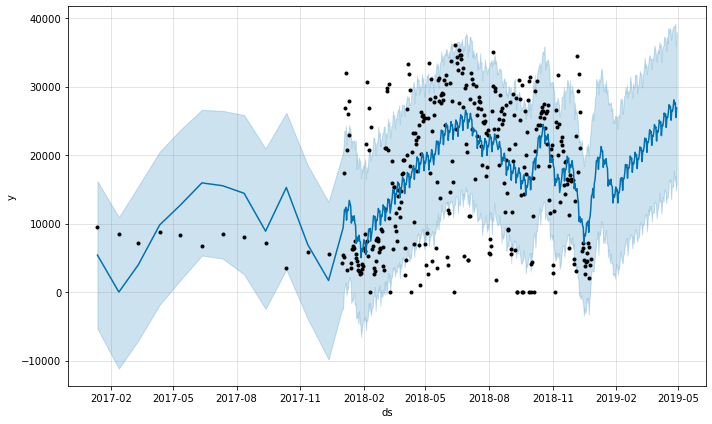

In [87]:
fig = m.plot(forecast)

The interpretation is that ```y``` is the actual value that the Prophet time series model is unaware of and the ```yhat``` is the predicted value. There is also the maximum (```yhat_upper```) and minimum (```yhat_lower```) confidence intervals. It is always necessary to observe whether the predicted value was contained between the confidence intervals.

In [88]:
forecast['y'] = df_test['y']
forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:]

,ds,y,yhat,yhat_lower,yhat_upper
394,2019-01-30,NaN,14302.749842,1959.034201,25719.236253
395,2019-01-31,NaN,15341.627191,3422.416055,25724.475424
396,2019-02-01,NaN,14793.399593,4102.796901,25525.150307
397,2019-02-02,NaN,15017.351430,3796.609959,25610.867568
398,2019-02-03,NaN,13006.231573,2523.363243,23802.768000
...,...,...,...,...,...
479,2019-04-25,NaN,28064.171200,17665.396127,38866.476005
480,2019-04-26,NaN,27499.788359,16253.591731,38689.682379
481,2019-04-27,NaN,27645.254376,16955.260644,39196.777607
482,2019-04-28,NaN,25499.815146,14832.605351,36009.025264


Now let's do the metric calculations to check the performance of the model.

In [89]:
se = np.square(forecast.loc[:, 'yhat'] - forecast['y'])
mse = np.mean(se) #Erro médio quadrado 
rmse = np.sqrt(mse)

print('mse ->', mse)
print('rmse ->', rmse)

mse -> 48856075.36357236
rmse -> 6989.712108776181


The metrics MSE and RMSE were chosen, where MSE is the Mean Squared Error, which demonstrates the average of the forecast error by raising it to the square and RMSE is the Root Mean Squared Error, which demonstrates the square root of MSE, and returns the error to unit.

The MSE and RMSE are excellent statistics for when we want to penalize larger errors and not tolerate errors that large.

The interpretation of the MSE and RMSE is the closer to zero, the better the model, however, it is necessary to analyze the context in which it is applied, to verify if the discrepancy of the value is really significant for analysis.

In our case both statistics appear high, which can mean a high error with respect to the predicted value.

Therefore, one of the solutions to try to lower the RMSE metric is to identify outliers in the data and remove them, as the RMSE squares the errors before calculating the average, and therefore, if there are outliers, the metric will also appear higher. The same happens with MSE, the removal of outliers can already help to lower it.

According to the MSE and RMSE analysis, the suggestion is to treat the outliers and also the hyperparameters that can help to better calibrate the model.

If not successful, Prophet may not be the best model to predict the database. Therefore, it is important to test new models, but first calculate the stationarity and seasonality of the database, using Dickey Fuller tests, in order to choose the model that best fits the data.

When the model fit was performed, the log showed that it would be necessary to use the year and day seasonality as True, demonstrating that there may be seasonality in the data. Therefore, perhaps the Triple Exponential Smoothing model (Holt-Winters Method) or even ARIMA can demonstrate better performance for this dataset.

In [93]:
#TODO: Pipeline